# March Machine Learning Mania 2023
## Forecast the 2023 NCAA Basketball Tournaments

Each season there are thousands of NCAA basketball games played between Division I college basketball teams, culminating in March Madness®, the 68-team national championship that starts in the middle of March.

The tournament teams include champions from 32 Division I conferences and 36 teams which are awarded at-large berths (selected by a committee). Teams are placed in four regions and given a seed between 1 and 16 within the region. The first week starts with eight teams competing in the First Four, with the four winners joining 60 teams to compete in the First and Second Rounds.

Sixteen winners advance to the second weekend to compete in the Regional Semifinals and Finals, also known as the Sweet Sixteen and Elite Eight, respectively, for the number of participants in the round. Four teams then advance to the third weekend for the National Semifinals and National Championship, collectively referred to as the Final Four. The winning team is crowned National Champion. 

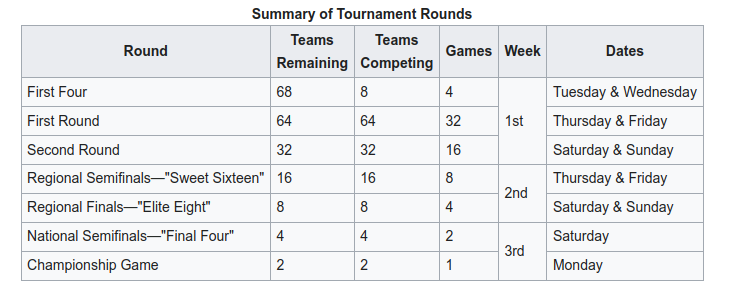

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data exploration

Prefixes:

* M_ - men's league
* W_ - women's league

In [49]:
# tourney data
M_tourney = pd.read_csv('data/MNCAATourneyDetailedResults.csv')
W_tourney = pd.read_csv('data/WNCAATourneyDetailedResults.csv')
# tourney seeds
M_seeds = pd.read_csv('data/MNCAATourneySeeds.csv')
W_seeds = pd.read_csv('data/WNCAATourneySeeds.csv')
# regular season data
M_regular = pd.read_csv('data/MRegularSeasonDetailedResults.csv')
W_regular = pd.read_csv('data/WRegularSeasonDetailedResults.csv')


In [50]:
print(f"M_regular shape: {M_regular.shape}")
print(f"M_tourney shape: {M_tourney.shape}")
print(f"M_seeds shape: {M_seeds.shape}")
print(f"W_regular shape: {W_regular.shape}")
print(f"W_tourney shape: {W_tourney.shape}")
print(f"W_seeds shape: {W_seeds.shape}")

M_regular shape: (107634, 34)
M_tourney shape: (1248, 34)
M_seeds shape: (2490, 3)
W_regular shape: (70783, 34)
W_tourney shape: (760, 34)
W_seeds shape: (1608, 3)


In [51]:
M_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [52]:
M_regular.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [53]:
M_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [54]:
print(all(M_tourney.columns == M_regular.columns))
print(all(W_regular.columns == W_tourney.columns))
print(all(M_regular.columns == W_regular.columns))

True
True
True


In [55]:
M_regular.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

Same columns for tourney and regular datasets. Column names explanation (W or L prefixes refer to winning or losing team) for winning team:

* WFGM - field goals made
* WFGA - field goals attempted
* WFGM3 - three pointers made 
* WFGA3 - three pointers attempted
* WFTM - free throws made
* WFTA - free throws attempted
* WOR - offensive rebounds
* WDR - defensive rebounds
* WAst - assists
* WTO - turnovers committed
* WStl - steals
* WBlk - blocks
* WPF - personal fouls committed

WLoc column says if the winning team was playing, away/at home/neutral (eg. tournaments)

In [56]:
M_tourney["WLoc"].unique() # in tourney every team plays in neutral court

array(['N'], dtype=object)

In [57]:
M_regular["WLoc"].value_counts() # in regular season most games are won on home court

H    63368
A    33239
N    11027
Name: WLoc, dtype: int64

In [58]:
W_seeds.tail()

,Season,Seed,TeamID
1603,2023,Z12,3405
1604,2023,Z13,3387
1605,2023,Z14,3241
1606,2023,Z15,3436
1607,2023,Z16,3151


We have information about the 2023 tournament seeding.

---

### Data preparation

#### regular season and tourney table
In this step we want to prepare the tables so that we can later extract features for each team. We're going to need the statistics of each team and their opponents. The idea is to have average performance of the team and the average performance of the teams they've played against. Because each row represent each match, we are duplicating the rows and switching sides. This way we have each match from the perspective of each team. 

In [59]:
def duplicate_and_switch_sides(df):
    # locationL
    #   - 1 if T1 plays home court
    #   - -1 if T1 plays away court
    #   - 0 if neutral court 
    df_copy = df.copy()
    df_copy["location"] = df_copy["WLoc"].apply(lambda x: "H" if x == "A" else "A" if x == "H" else "N")
    df_copy.drop(columns=["WLoc"], inplace=True)
    df_copy.columns = df_copy.columns.str.replace('W', 'T2_').str.replace('L', 'T1_')
    
    df["location"] = df["WLoc"]
    df.drop(columns=["WLoc"], inplace=True)

    df.columns = df.columns.str.replace('W','T1_').str.replace('L','T2_')
    
    
    result = pd.concat([df, df_copy],axis=0)
    result["location"] = result["location"].apply(lambda x: 1 if x == "H" else 0 if x == "N" else -1)
    result["point_diff"] = result["T1_Score"] - result["T2_Score"]
    result.sort_values(by=["Season", "T1_TeamID", "T2_TeamID"], inplace=True)
    result.reset_index(drop=True, inplace=True)
    return result   
    

In [60]:
M_regular_working = duplicate_and_switch_sides(M_regular)
W_regular_working = duplicate_and_switch_sides(W_regular)
M_tourney_working = duplicate_and_switch_sides(M_tourney)
W_tourney_working = duplicate_and_switch_sides(W_tourney)   

#### Seeding tables
We don't need the letter prefix for seeds.


In [61]:
def correct_seeds(df):
    df_copy = df.copy()
    df_copy["Seed"] = df_copy["Seed"].apply(lambda x: int(x[1:3]))
    return df_copy 

In [62]:
M_seeds_working = correct_seeds(M_seeds)
W_seeds_working = correct_seeds(W_seeds)   

In [63]:
M_seeds_working

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374
...,...,...,...
2485,2023,12,1433
2486,2023,13,1233
2487,2023,14,1213
2488,2023,15,1421


#### Conferences
Regular season matches may not be a good indicator of a team's performance when comparing two teams from different conferences. There are conferences with greater average "skill" than others. A team might go 18-0 in a weak conference, completely stomping other teams, yet still be worse then teams from other stronger conferences.  In this step we're only preparing the data. The actual features will be made in the next section.

In [64]:
M_conferences = pd.read_csv('data/MTeamConferences.csv')
W_conferences = pd.read_csv('data/WTeamConferences.csv')

In [65]:
def prepare_conferences(df_regular, df_conferences):
    df_regular_copy = df_regular[["Season", "T1_TeamID", "T2_TeamID", "location", "point_diff"]].copy()
    result = df_regular_copy.merge(df_conferences, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"]).rename(columns={"ConfAbbrev": "T1_ConfAbbrev"})
    result = result.merge(df_conferences, how="left", left_on=["Season", "T2_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"]).rename(columns={"ConfAbbrev": "T2_ConfAbbrev"})
    return result

In [66]:
M_conferences_working = prepare_conferences(M_regular_working, M_conferences)
W_conferences_working = prepare_conferences(W_regular_working, W_conferences)

In [67]:
M_conferences_working

,Season,T1_TeamID,T2_TeamID,location,point_diff,T1_ConfAbbrev,T2_ConfAbbrev
0,2003,1102,1117,-1,5,mwc,sun_belt
1,2003,1102,1125,1,9,mwc,a_sun
2,2003,1102,1140,-1,-32,mwc,mwc
3,2003,1102,1140,1,-13,mwc,mwc
4,2003,1102,1161,1,5,mwc,mwc
...,...,...,...,...,...,...,...
215263,2023,1477,1394,-1,4,southland,southland
215264,2023,1477,1394,1,-5,southland,southland
215265,2023,1477,1400,-1,-25,southland,big_twelve
215266,2023,1477,1421,0,-8,southland,big_south


#### Massey
This file lists out rankings of men's teams going back to the 2002-2003 season, under a large number of different ranking system methodologies. The ranking are usually updated every week. 

 For now what we're going to do is just an average rank for each team for each ranking's update day.   

In [68]:
M_massey = pd.read_csv('data/MMasseyOrdinals_thru_Season2023_Day128.csv')
# table with the last ranking before the tournament
M_massey_working = M_massey.groupby(["Season", "RankingDayNum", "TeamID", ]).mean().reset_index()
M_massey_tourney = M_massey_working.groupby(["Season", "TeamID"])[["RankingDayNum","OrdinalRank"]].max("RankingDayNum").reset_index()[['Season', 'TeamID', 'OrdinalRank']]
M_massey_tourney

/tmp/ipykernel_24611/3999543452.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  M_massey_working = M_massey.groupby(["Season", "RankingDayNum", "TeamID", ]).mean().reset_index()


,Season,TeamID,OrdinalRank
0,2003,1102,191.000000
1,2003,1103,284.000000
2,2003,1104,54.000000
3,2003,1105,315.222222
4,2003,1106,291.000000
...,...,...,...
7260,2023,1473,347.454545
7261,2023,1474,263.590909
7262,2023,1475,272.887097
7263,2023,1476,329.454545


<Axes: >

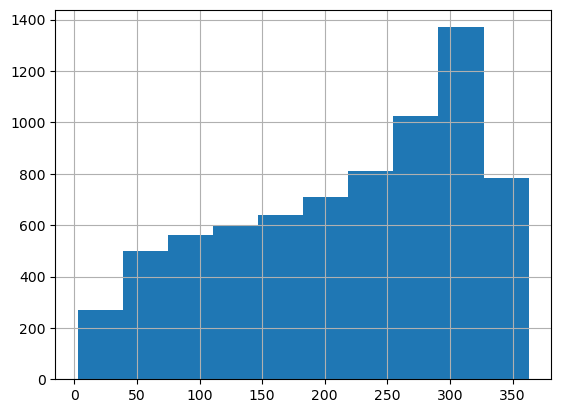

In [69]:
M_massey_tourney["OrdinalRank"].hist()

#### Women league ranking
From [Kaggle NCAA Women 538 team ratings dataset](https://www.kaggle.com/datasets/raddar/ncaa-women-538-team-ratings). Rankings from 2016 to 2023. Last updated before the 2023 tourney. Therefore we can use it.  TeamID are consistent with used up to now datasets.  

In [70]:
W_ratings = pd.read_csv('data/WRatings.csv').rename(columns={"538rating": "Rating"})

#### Historic team data
Tourney appearances and results for each team in tourneys from 2008 to 2022. "Mtournament_team_data.csv" From this [Kaggle link](https://www.kaggle.com/datasets/nishaanamin/.march-madness-data). There's no available data for women's league.

In [71]:
M_tournament_teams = pd.read_csv('data/Mtournament_team_data.csv')[["YEAR", "TEAM", "ROUND"]]
M_teams_dict = pd.read_csv('data/MTeamSpellings.csv', encoding='latin-1')

In [72]:
M_tournament_teams

,YEAR,TEAM,ROUND
0,2022,Kansas,1
1,2022,Arizona,16
2,2022,Gonzaga,16
3,2022,Baylor,32
4,2022,Duke,4
...,...,...,...
938,2008,Mississippi Valley St.,64
939,2008,Mount St. Mary's,64
940,2008,Portland St.,64
941,2008,UT Arlington,64


---

### Feature engineering


In [73]:

def prepare_regular_season_team_statistics(regular_df):
   df = regular_df.copy()
   
   # create some new columns for regular season
   # shot percentage
   df["T1_FG%"] = df["T1_FGM"] / df["T1_FGA"]
   df["T2_FG%"] = df["T2_FGM"] / df["T2_FGA"] 
   df["T1_3P%"] = df["T1_FGM3"] / df["T2_FGA3"]
   df["T2_3P%"] = df["T2_FGM3"] / df["T2_FGA3"]
   # win/lose
   df["win"] = np.where(df["point_diff"] > 0, 1, 0)
   
   agg_func = [np.mean]
   # location difference
   points_columns = ["T1_FG%", "T1_3P%", "point_diff", "win"]
   home_statistics = df.loc[df["location"] == 1].groupby(["Season", "T1_TeamID"])[points_columns].agg(agg_func).reset_index()   
   away_statistics = df.loc[df["location"] != -1].groupby(["Season", "T1_TeamID"])[points_columns].agg(agg_func).reset_index()
   
   home_statistics.columns = ['_home_'.join(col).strip() if  col[0] not in ["Season", "T1_TeamID"] else col[0] for col in home_statistics.columns.values]
   away_statistics.columns = ['_away_'.join(col).strip() if  col[0] not in ["Season", "T1_TeamID"] else col[0] for col in away_statistics.columns.values]
   
   
   # means of regular season depending on season, team
   statistics_columns = ["T1_Score","T2_Score", "T1_FGM", 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA',
      'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR',
      'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'T1_FG%', 'T2_FG%', 'T1_3P%', 'T2_3P%', 'point_diff', 'win']

   
   # overall statistics
   season_statistics = df.loc[df["location"] == 1].groupby(["Season", "T1_TeamID"])[statistics_columns].agg(agg_func).reset_index()   
   season_statistics.columns = ['_'.join(col).strip() if  col[0] not in ["Season", "T1_TeamID"] else col[0] for col in season_statistics.columns.values]

   # df_team will be the final dataframe, it's going to be a merge of all the other dataframes with statistics
   df_team = regular_df.copy()[["Season", "T1_TeamID"]].drop_duplicates()
   df_team = df_team.merge(home_statistics, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
   df_team = df_team.merge(away_statistics, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
   df_team = df_team.merge(season_statistics, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
   
   
   win_ratio_last_month_df = df.loc[df["DayNum"] > 102].groupby(["Season", "T1_TeamID"])["win"].mean().reset_index().rename(columns={"win": "win_ratio_last_month"})
   df_team = df_team.merge(win_ratio_last_month_df, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
   
   
   return df_team


def prepare_previous_tourney_data(tourney_df, df_team):
    # here we will create a dataframe with the previous tournament data for each team
    # we look at a team's previous tournament data, whether they played in the tournament or not, and their performance
    df = tourney_df.copy()
    df["win"] = np.where(df["point_diff"] > 0, 1, 0)
    win_ratio_by_team = df.groupby(["Season", "T1_TeamID"])["win"].mean().reset_index().groupby(["T1_TeamID"])
    grouped_dfs = []

    for team, group in win_ratio_by_team:
        new_rows = []
        group = group.set_index("Season")  # set the index to the season
        group["played_tourney"] = 1
        missing_years = set(range(group.index.min(), group.index.max()+2)) - set(group.index)
        for year in missing_years:
            prev_year = year - 1
            if prev_year in group.index:
                prev_ratio = group.loc[prev_year, "win"]
                new_rows.append({"T1_TeamID": team, "Season": year, "win": prev_ratio, "played_tourney": 0})
            else:
                new_rows.append({"T1_TeamID": team, "Season": year, "win": 0, "played_tourney": 0})

        new_df = pd.concat([group, pd.DataFrame(new_rows).set_index("Season")]).sort_index().reset_index()
        new_df["prev_win_ratio"] = new_df["win"].shift(1).fillna(0)
        new_df["played_prev_tourney"] = new_df["played_tourney"].shift(1).fillna(0)
        new_df.drop(columns=["win","played_tourney"], inplace=True)
        grouped_dfs.append(new_df)
    previous_tourneys = pd.concat(grouped_dfs).reset_index(drop=True)
    team_df = df_team.copy().merge(previous_tourneys, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
    team_df["prev_win_ratio"].fillna(0, inplace=True)
    team_df["played_prev_tourney"].fillna(0, inplace=True)
    return team_df
   
    
    

In [74]:
# men's data preparation
M_teams_working = prepare_regular_season_team_statistics(M_regular_working)
M_teams_working = prepare_previous_tourney_data(M_tourney_working, M_teams_working)

# merge with seeding, if Seed == 0 then the team didn't play in the tournament
M_teams_working = M_teams_working.merge(M_seeds_working, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"])
# only for men's league - merge with massey ordinals, this is a rank that a team has at the end of the season
M_teams_working = M_teams_working.merge(M_massey_tourney, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"])

/tmp/ipykernel_24611/4190583622.py:55: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for team, group in win_ratio_by_team:


In [75]:
# women's data preparation
W_teams_working = prepare_regular_season_team_statistics(W_regular_working)
W_teams_working = prepare_previous_tourney_data(W_tourney_working, W_teams_working)
W_teams_working = W_teams_working.merge(W_seeds_working, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"])
W_teams_working = W_teams_working.merge(W_ratings, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID", "TeamName"])
W_teams_working["Rating"].fillna(W_teams_working["Rating"].mean(), inplace=True) # there are many missing ratings

/tmp/ipykernel_24611/4190583622.py:55: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for team, group in win_ratio_by_team:


<Axes: >

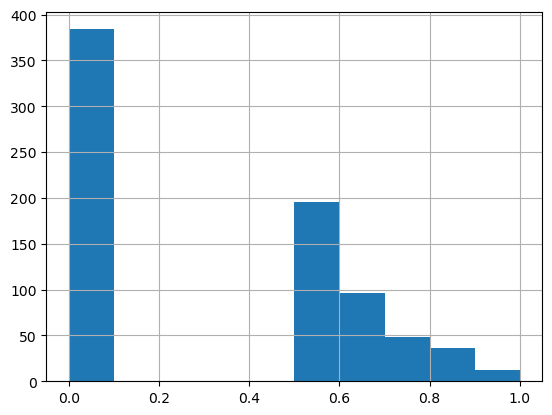

In [76]:
W_teams_working.loc[W_teams_working["played_prev_tourney"]==1].prev_win_ratio.hist()

<Axes: >

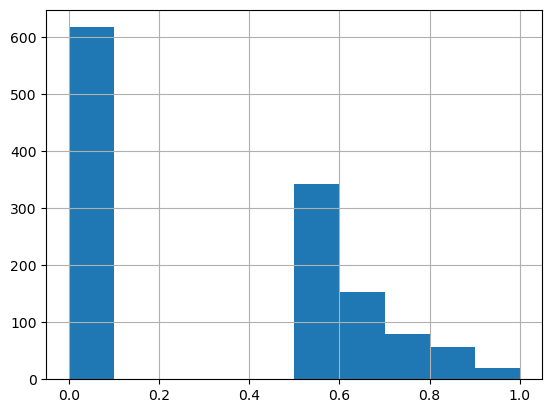

In [77]:
M_teams_working.loc[M_teams_working["played_prev_tourney"]==1].prev_win_ratio.hist()

#### Men's league toruney appearances

In [78]:
def prepare_Mtourney_appearances(M_tournament_teams, M_teams_dict):
    df_tourney_teams = M_tournament_teams.copy()
    df_teams_dict = M_teams_dict.copy()
    
    
    df_tourney_teams["TEAM"] = df_tourney_teams["TEAM"].str.lower()
    df_tourney_teams = df_tourney_teams.merge(M_teams_dict, how="left", left_on=["TEAM"], right_on=["TeamNameSpelling"]).drop(columns=["TeamNameSpelling","TEAM"]).rename(columns={"YEAR": "Season"})
    df_tourney_teams.dropna(inplace=True)
    df_tourney_teams.reset_index(drop=True,inplace=True)
    df_tourney_teams["TeamID"] = df_tourney_teams["TeamID"].astype(int)
    
    appearances = df_tourney_teams.groupby(["Season","TeamID"])["ROUND"].value_counts().unstack().fillna(0).astype(int).reset_index()
    appearances.columns = [f"top{col}_appearances" if col not in  ["TeamID", "Season"] else col for col in appearances.columns.values]
    appearances["total_tourney_appearances"] = appearances[[col for col in appearances.columns.values if col not in ["TeamID","Season"]]].sum(axis=1)
    appearances.set_index(["Season","TeamID"], inplace=True)
    appearances = appearances.groupby("TeamID")[[col for col in appearances.columns.values if col not in ["TeamID","Season"]]].cumsum().reset_index()
    appearances_grouped = appearances.groupby("TeamID")
    new_rows = []
    for team, group in appearances_grouped:
        group = group.set_index("Season")  
        missing_years = set(range(group.index.min(), group.index.max()+1)) - set(group.index)
        for year in missing_years:
            prev_year = year - 1
            if prev_year in group.index:
                new_row = group.loc[prev_year].copy()
                new_row.name = year
                new_rows.append(new_row)
    new_df = pd.DataFrame(new_rows).reset_index().rename(columns={"index": "Season"})
    appearances = pd.concat([appearances, new_df]).sort_values(by=["Season","TeamID"]).reset_index(drop=True)
    appearances["Season"] = appearances["Season"] + 1 # appearances before this year's tourney
    return appearances
    

In [79]:
M_tourney_appearances = prepare_Mtourney_appearances(M_tournament_teams, M_teams_dict)
M_teams_working = M_teams_working.merge(M_tourney_appearances, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "TeamID"]).drop(columns=["TeamID"])
M_teams_working[['top1_appearances', 'top2_appearances', 'top4_appearances', 'top8_appearances', 'top16_appearances','top32_appearances','top64_appearances', 'top68_appearances', 'total_tourney_appearances']] = M_teams_working[['top1_appearances', 'top2_appearances', 'top4_appearances', 'top8_appearances', 'top16_appearances', 'top32_appearances', 'top64_appearances', 'top68_appearances', 'total_tourney_appearances']].fillna(0).astype(int)

#### Conference margin

In [80]:
def prepare_conference_margin(conference_df, df_teams):
    df = conference_df.copy()
    df["win"] = np.where(df["point_diff"] > 0, 1, 0)
    conf_margin = df.groupby(["Season", "T1_ConfAbbrev", "T2_ConfAbbrev"])[["point_diff","win"]].mean().reset_index().rename(columns={"point_diff": "conf_point_margin","win": "conf_win_margin"})
    conf_margin_grouped = conf_margin.groupby(["Season"])
    margin_dfs = []
    for name, group in conf_margin_grouped:
        point_margin_matrix = group.reset_index().pivot_table(index="T1_ConfAbbrev", columns="T2_ConfAbbrev", values="conf_point_margin")
        point_margin_matrix = point_margin_matrix.reset_index().melt(id_vars="T1_ConfAbbrev", var_name="T2_ConfAbbrev", value_name="conf_point_margin").groupby(["T1_ConfAbbrev"])["conf_point_margin"].mean().reset_index()
        point_margin_matrix["Season"] = name


        win_margin_matrix = group.reset_index().pivot_table(index="T1_ConfAbbrev", columns="T2_ConfAbbrev", values="conf_win_margin")
        win_margin_matrix = win_margin_matrix.reset_index().melt(id_vars="T1_ConfAbbrev", var_name="T2_ConfAbbrev", value_name="conf_win_margin").groupby(["T1_ConfAbbrev"])["conf_win_margin"].mean().reset_index()
        win_margin_matrix["Season"] = name
        
        margin_dfs.append(point_margin_matrix.merge(win_margin_matrix, how="left", left_on=["Season", "T1_ConfAbbrev"], right_on=["Season", "T1_ConfAbbrev"]))
    conf_margin_df = pd.concat(margin_dfs).reset_index(drop=True)
    merged = conference_df[["Season","T1_TeamID","T1_ConfAbbrev"]].merge(conf_margin_df, how="left", left_on=["Season", "T1_ConfAbbrev"], right_on=["Season", "T1_ConfAbbrev"]).drop(columns=["T1_ConfAbbrev"]).drop_duplicates()
    result = df_teams.merge(merged, how="left", left_on=["Season", "T1_TeamID"], right_on=["Season", "T1_TeamID"])
    return result
    

In [81]:
M_teams_working = prepare_conference_margin(M_conferences_working, M_teams_working)
W_teams_working = prepare_conference_margin(W_conferences_working, W_teams_working)

/tmp/ipykernel_24611/4154837743.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in conf_margin_grouped:
/tmp/ipykernel_24611/4154837743.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in conf_margin_grouped:


In [82]:
W_teams_working.isna().sum()

Season                     0
T1_TeamID                  0
T1_FG%_home_mean          37
T1_3P%_home_mean          48
point_diff_home_mean      37
win_home_mean             37
T1_FG%_away_mean           0
T1_3P%_away_mean          13
point_diff_away_mean       0
win_away_mean              0
T1_Score_mean             37
T2_Score_mean             37
T1_FGM_mean               37
T1_FGA_mean               37
T1_FGM3_mean              37
T1_FGA3_mean              37
T1_FTM_mean               37
T1_FTA_mean               37
T1_OR_mean                37
T1_DR_mean                37
T1_Ast_mean               37
T1_TO_mean                37
T1_Stl_mean               37
T1_Blk_mean               37
T1_PF_mean                37
T2_FGM_mean               37
T2_FGA_mean               37
T2_FGM3_mean              37
T2_FGA3_mean              37
T2_FTM_mean               37
T2_FTA_mean               37
T2_OR_mean                37
T2_DR_mean                37
T2_Ast_mean               37
T2_TO_mean    

In [83]:
def final_preparation(working_df, tourney_df):
    # this function might require more than 8GB of RAM, it works on my machine with 16GB of RAM with many other applications running
    df = working_df.copy()
    
    #first merge all possible combinations of teams
    df.columns = df.columns.str.replace("T2_", "opponent_")
    df.columns  = [f"T1_{col}" if not col.startswith("T1_") and not col=="Season" else col for col in df.columns.values ]
    df_T2 = df.copy()
    df_T2.columns = [col.replace("T1_", "T2_") for col in df_T2.columns.values]
    df_merged = df.merge(df_T2, how="outer", on=["Season"])
    df_merged = df_merged[df_merged["T1_TeamID"] != df_merged["T2_TeamID"]] # remove rows where team is playing itself
    del df_T2, df # delete to save memory
    
    # split into train dataset and solution dataset
    df_final_2023 = df_merged[df_merged["Season"] == 2023]
    df_final = df_merged[df_merged["Season"] < 2023]
    df_final = df_final[df_final["T1_Seed"].notnull()] # remove rows without seed - they didn't play in the tourney, this should substantially reduce the RAM usage, without loss of information
    
    # generate ID in solution dataset
    df_final_2023 = df_final_2023.sort_values(by=["T1_TeamID","T2_TeamID"]) 
    df_final_2023 = df_final_2023.query("T1_TeamID < T2_TeamID").copy()
    df_final_2023["ID"] = df_final_2023["Season"].astype(str) + "_" + df_final_2023["T1_TeamID"].astype(str) + "_" + df_final_2023["T2_TeamID"].astype(str)
    df_final_2023.reset_index(drop=True, inplace=True)
    
    # merge match results from previous tourneys
    past_tourneys = tourney_df.copy()[["Season","T1_TeamID","T2_TeamID", "point_diff"]]
    past_tourneys["win"] = np.where(past_tourneys["point_diff"] > 0, 1, 0)
    past_tourneys = past_tourneys.drop(columns=["point_diff"])
    df_final = df_final.merge(past_tourneys, how="left", on=["Season","T1_TeamID","T2_TeamID"])
    df_final = df_final[df_final["win"].notnull()] # remove matches that didn't happen in previous tourneys
       
    # add seed difference
    df_final["seed_diff"] = df_final["T1_Seed"] - df_final["T2_Seed"]
    df_final_2023["seed_diff"] = df_final_2023["T1_Seed"] - df_final_2023["T2_Seed"]
    
    
    return df_final, df_final_2023
    

In [84]:
M_train, M_solution = final_preparation(M_teams_working, M_tourney_working)
W_train, W_solution = final_preparation(W_teams_working, W_tourney_working)

In [85]:
M_train

,Season,T1_TeamID,T1_FG%_home_mean,T1_3P%_home_mean,T1_point_diff_home_mean,T1_win_home_mean,T1_FG%_away_mean,T1_3P%_away_mean,T1_point_diff_away_mean,T1_win_away_mean,...,T2_top8_appearances,T2_top16_appearances,T2_top32_appearances,T2_top64_appearances,T2_top68_appearances,T2_total_tourney_appearances,T2_conf_point_margin,T2_conf_win_margin,win,seed_diff
115,2003,1104,0.433635,0.363928,11.733333,0.866667,0.425919,0.395321,9.684211,0.842105,...,0,0,0,0,0,0,10.714820,0.761294,0.0,3.0
425,2003,1112,0.472727,0.412883,18.800000,0.933333,0.466619,0.416245,17.187500,0.875000,...,0,0,0,0,0,0,1.544091,0.638742,1.0,-8.0
452,2003,1112,0.472727,0.412883,18.800000,0.933333,0.466619,0.416245,17.187500,0.875000,...,0,0,0,0,0,0,13.314434,0.773848,0.0,-1.0
521,2003,1112,0.472727,0.412883,18.800000,0.933333,0.466619,0.416245,17.187500,0.875000,...,0,0,0,0,0,0,12.576436,0.723768,1.0,-4.0
625,2003,1112,0.472727,0.412883,18.800000,0.933333,0.466619,0.416245,17.187500,0.875000,...,0,0,0,0,0,0,-4.980667,0.323778,1.0,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434016,2022,1458,0.428291,0.367420,6.500000,0.750000,0.423013,0.366356,5.850000,0.750000,...,0,0,0,0,0,0,15.169185,0.862019,0.0,-8.0
434256,2022,1460,0.479648,0.327450,8.000000,0.785714,0.469896,0.328515,5.578947,0.684211,...,0,0,0,0,0,0,8.376615,0.645487,0.0,15.0
434276,2022,1460,0.479648,0.327450,8.000000,0.785714,0.469896,0.328515,5.578947,0.684211,...,0,0,0,0,0,0,-12.439537,0.176321,1.0,0.0
434726,2022,1461,0.491874,0.355008,12.428571,0.928571,0.473531,0.380543,9.947368,0.842105,...,0,0,0,0,0,0,12.258611,0.832315,0.0,0.0


In [86]:
M_solution.loc[M_solution["seed_diff"].notnull(),:]

,Season,T1_TeamID,T1_FG%_home_mean,T1_3P%_home_mean,T1_point_diff_home_mean,T1_win_home_mean,T1_FG%_away_mean,T1_3P%_away_mean,T1_point_diff_away_mean,T1_win_away_mean,...,T2_top8_appearances,T2_top16_appearances,T2_top32_appearances,T2_top64_appearances,T2_top68_appearances,T2_total_tourney_appearances,T2_conf_point_margin,T2_conf_win_margin,ID,seed_diff
1089,2023,1104,0.476403,0.599906,24.533333,1.000000,0.465526,0.595739,18.590909,0.909091,...,3,4,0,3,0,10,10.441923,0.729824,2023_1104_1112,-1.0
1090,2023,1104,0.476403,0.599906,24.533333,1.000000,0.465526,0.595739,18.590909,0.909091,...,0,0,0,0,0,0,10.441923,0.729824,2023_1104_1113,-10.0
1093,2023,1104,0.476403,0.599906,24.533333,1.000000,0.465526,0.595739,18.590909,0.909091,...,2,0,3,1,0,6,10.296298,0.770906,2023_1104_1116,-7.0
1096,2023,1104,0.476403,0.599906,24.533333,1.000000,0.465526,0.595739,18.590909,0.909091,...,0,0,2,0,0,3,10.296298,0.770906,2023_1104_1120,-8.0
1099,2023,1104,0.476403,0.599906,24.533333,1.000000,0.465526,0.595739,18.590909,0.909091,...,2,2,2,3,0,10,15.794781,0.878826,2023_1104_1124,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64936,2023,1436,0.508349,0.474473,14.461538,0.923077,0.493740,0.445818,8.823529,0.764706,...,0,0,0,0,0,0,15.794781,0.878826,2023_1436_1452,6.0
64946,2023,1436,0.508349,0.474473,14.461538,0.923077,0.493740,0.445818,8.823529,0.764706,...,0,0,0,0,0,0,14.485119,0.820011,2023_1436_1462,12.0
65011,2023,1438,0.463373,0.373820,12.187500,0.937500,0.462348,0.344585,10.952381,0.904762,...,0,0,0,0,0,0,15.794781,0.878826,2023_1438_1452,-5.0
65021,2023,1438,0.463373,0.373820,12.187500,0.937500,0.462348,0.344585,10.952381,0.904762,...,0,0,0,0,0,0,14.485119,0.820011,2023_1438_1462,1.0


In [87]:
W_train

,Season,T1_TeamID,T1_FG%_home_mean,T1_3P%_home_mean,T1_point_diff_home_mean,T1_win_home_mean,T1_FG%_away_mean,T1_3P%_away_mean,T1_point_diff_away_mean,T1_win_away_mean,...,T2_win_mean,T2_win_ratio_last_month,T2_prev_win_ratio,T2_played_prev_tourney,T2_Seed,T2_Rating,T2_conf_point_margin,T2_conf_win_margin,win,seed_diff
101,2010,3114,0.457909,0.401898,20.235294,0.882353,0.455716,0.386934,17.157895,0.789474,...,0.857143,0.428571,0.000000,0.0,6.0,83.212939,14.475932,0.814189,1.0,5.0
210,2010,3114,0.457909,0.401898,20.235294,0.882353,0.455716,0.386934,17.157895,0.789474,...,0.785714,0.600000,0.000000,0.0,3.0,83.212939,17.941846,0.853491,0.0,8.0
620,2010,3122,0.418785,0.324334,1.062500,0.562500,0.419130,0.301921,1.833333,0.611111,...,1.000000,1.000000,0.000000,0.0,1.0,83.212939,18.067323,0.797815,0.0,15.0
738,2010,3124,0.482245,0.139415,27.411765,0.882353,0.481290,0.138026,23.000000,0.863636,...,1.000000,1.000000,0.000000,0.0,1.0,83.212939,15.065471,0.817384,0.0,3.0
756,2010,3124,0.482245,0.139415,27.411765,0.882353,0.481290,0.138026,23.000000,0.863636,...,0.944444,0.875000,0.000000,0.0,2.0,83.212939,14.475932,0.814189,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266271,2022,3428,0.449876,0.542664,18.733333,0.733333,0.439770,0.545249,13.238095,0.714286,...,0.800000,1.000000,0.750000,1.0,2.0,95.210000,17.372917,0.818292,0.0,5.0
266373,2022,3437,0.409058,0.545034,7.428571,0.857143,0.404712,0.553542,6.125000,0.812500,...,1.000000,0.857143,0.500000,1.0,6.0,88.950000,1.854467,0.514532,1.0,5.0
266506,2022,3437,0.409058,0.545034,7.428571,0.857143,0.404712,0.553542,6.125000,0.812500,...,1.000000,0.400000,0.666667,1.0,3.0,90.120000,13.941647,0.750906,0.0,8.0
266781,2022,3439,0.451054,0.661976,20.214286,0.857143,0.452515,0.624041,15.473684,0.789474,...,0.846154,0.875000,0.000000,1.0,12.0,83.190000,-4.802849,0.415264,0.0,-7.0


In [88]:
W_solution

,Season,T1_TeamID,T1_FG%_home_mean,T1_3P%_home_mean,T1_point_diff_home_mean,T1_win_home_mean,T1_FG%_away_mean,T1_3P%_away_mean,T1_point_diff_away_mean,T1_win_away_mean,...,T2_win_mean,T2_win_ratio_last_month,T2_prev_win_ratio,T2_played_prev_tourney,T2_Seed,T2_Rating,T2_conf_point_margin,T2_conf_win_margin,ID,seed_diff
0,2023,3101,0.447134,0.544846,10.363636,0.727273,0.434991,0.490211,7.285714,0.642857,...,0.583333,0.142857,0.0,0.0,NaN,83.212939,4.731622,0.564406,2023_3101_3102,NaN
1,2023,3101,0.447134,0.544846,10.363636,0.727273,0.434991,0.490211,7.285714,0.642857,...,0.642857,0.375000,0.0,0.0,NaN,83.212939,-1.167932,0.555293,2023_3101_3103,NaN
2,2023,3101,0.447134,0.544846,10.363636,0.727273,0.434991,0.490211,7.285714,0.642857,...,0.687500,0.333333,0.0,0.0,10.0,82.910000,19.009385,0.797350,2023_3101_3104,NaN
3,2023,3101,0.447134,0.544846,10.363636,0.727273,0.434991,0.490211,7.285714,0.642857,...,0.818182,0.500000,0.0,0.0,NaN,83.212939,-17.012472,0.151596,2023_3101_3105,NaN
4,2023,3101,0.447134,0.544846,10.363636,0.727273,0.434991,0.490211,7.285714,0.642857,...,0.818182,0.666667,0.0,0.0,NaN,83.212939,-17.012472,0.151596,2023_3101_3106,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64975,2023,3474,0.355432,0.316303,-14.666667,0.250000,0.355432,0.316303,-14.666667,0.250000,...,0.333333,0.600000,0.0,0.0,NaN,83.212939,-13.807939,0.236067,2023_3474_3476,NaN
64976,2023,3474,0.355432,0.316303,-14.666667,0.250000,0.355432,0.316303,-14.666667,0.250000,...,0.636364,0.400000,0.0,0.0,NaN,83.212939,-13.722222,0.256902,2023_3474_3477,NaN
64977,2023,3475,0.403459,0.355261,1.818182,0.454545,0.403459,0.355261,1.818182,0.454545,...,0.333333,0.600000,0.0,0.0,NaN,83.212939,-13.807939,0.236067,2023_3475_3476,NaN
64978,2023,3475,0.403459,0.355261,1.818182,0.454545,0.403459,0.355261,1.818182,0.454545,...,0.636364,0.400000,0.0,0.0,NaN,83.212939,-13.722222,0.256902,2023_3475_3477,NaN


In [89]:
cols = M_train.columns.values
for col in cols:
    print(col)

Season
T1_TeamID
T1_FG%_home_mean
T1_3P%_home_mean
T1_point_diff_home_mean
T1_win_home_mean
T1_FG%_away_mean
T1_3P%_away_mean
T1_point_diff_away_mean
T1_win_away_mean
T1_Score_mean
T1_opponent_Score_mean
T1_FGM_mean
T1_FGA_mean
T1_FGM3_mean
T1_FGA3_mean
T1_FTM_mean
T1_FTA_mean
T1_OR_mean
T1_DR_mean
T1_Ast_mean
T1_TO_mean
T1_Stl_mean
T1_Blk_mean
T1_PF_mean
T1_opponent_FGM_mean
T1_opponent_FGA_mean
T1_opponent_FGM3_mean
T1_opponent_FGA3_mean
T1_opponent_FTM_mean
T1_opponent_FTA_mean
T1_opponent_OR_mean
T1_opponent_DR_mean
T1_opponent_Ast_mean
T1_opponent_TO_mean
T1_opponent_Stl_mean
T1_opponent_Blk_mean
T1_opponent_PF_mean
T1_FG%_mean
T1_opponent_FG%_mean
T1_3P%_mean
T1_opponent_3P%_mean
T1_point_diff_mean
T1_win_mean
T1_win_ratio_last_month
T1_prev_win_ratio
T1_played_prev_tourney
T1_Seed
T1_OrdinalRank
T1_top1_appearances
T1_top2_appearances
T1_top4_appearances
T1_top8_appearances
T1_top16_appearances
T1_top32_appearances
T1_top64_appearances
T1_top68_appearances
T1_total_tourney_appea

In [90]:
M_train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [91]:
W_train.isnull().sum().values

array([ 0,  0, 14, 25, 14, 14,  0, 13,  0,  0, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 25, 14, 14, 14,  0,  0,  0,  0,  0,  0,  0,
        0, 14, 25, 14, 14,  0, 13,  0,  0, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 25, 14, 14, 14,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

In [96]:
W_solution.loc[M_solution["seed_diff"].notnull(),:]

,Season,T1_TeamID,T1_FG%_home_mean,T1_3P%_home_mean,T1_point_diff_home_mean,T1_win_home_mean,T1_FG%_away_mean,T1_3P%_away_mean,T1_point_diff_away_mean,T1_win_away_mean,...,T2_win_mean,T2_win_ratio_last_month,T2_prev_win_ratio,T2_played_prev_tourney,T2_Seed,T2_Rating,T2_conf_point_margin,T2_conf_win_margin,ID,seed_diff
1089,2023,3104,0.428885,1.159632,14.875000,0.687500,0.432694,1.068102,13.000000,0.666667,...,0.416667,0.500000,0.0,0.0,NaN,83.212939,-10.432386,0.197982,2023_3104_3119,NaN
1090,2023,3104,0.428885,1.159632,14.875000,0.687500,0.432694,1.068102,13.000000,0.666667,...,0.722222,0.333333,0.0,0.0,NaN,83.212939,19.009385,0.797350,2023_3104_3120,NaN
1093,2023,3104,0.428885,1.159632,14.875000,0.687500,0.432694,1.068102,13.000000,0.666667,...,0.647059,0.375000,0.5,1.0,7.0,86.610000,17.129535,0.839598,2023_3104_3124,3.0
1096,2023,3104,0.428885,1.159632,14.875000,0.687500,0.432694,1.068102,13.000000,0.666667,...,0.583333,0.000000,0.0,0.0,NaN,83.212939,-10.633576,0.220490,2023_3104_3127,NaN
1099,2023,3104,0.428885,1.159632,14.875000,0.687500,0.432694,1.068102,13.000000,0.666667,...,0.823529,0.777778,0.0,0.0,NaN,83.212939,-10.432386,0.197982,2023_3104_3131,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64816,2023,3459,0.442601,0.429802,13.400000,0.800000,0.426519,0.440324,11.076923,0.769231,...,0.533333,0.750000,0.0,0.0,NaN,83.212939,-13.807939,0.236067,2023_3459_3467,NaN
64826,2023,3459,0.442601,0.429802,13.400000,0.800000,0.426519,0.440324,11.076923,0.769231,...,0.636364,0.400000,0.0,0.0,NaN,83.212939,-13.722222,0.256902,2023_3459_3477,NaN
64924,2023,3466,0.404125,0.744303,4.166667,0.583333,0.404125,0.744303,4.166667,0.583333,...,0.636364,0.400000,0.0,0.0,NaN,83.212939,-13.722222,0.256902,2023_3466_3477,NaN
64936,2023,3468,0.402861,0.177346,-2.769231,0.384615,0.408277,0.187477,-2.866667,0.400000,...,0.416667,0.166667,0.0,0.0,NaN,83.212939,-0.502354,0.447493,2023_3468_3470,NaN


In [98]:
M_train.to_csv("final_datasets/M_train.csv", index=False)
M_solution.loc[M_solution["seed_diff"].notnull(),:].to_csv("final_datasets/M_solution.csv", index=False)
W_train.to_csv("final_datasets/W_train.csv", index=False)

W_solution_csv = W_solution.loc[W_solution["seed_diff"].notnull(),:]
W_solution_csv = W_solution_csv.fillna(0) # idk why there are 25 some missing values 
W_solution_csv.to_csv("final_datasets/W_solution.csv", index=False)